# Problem set 1

## Is your house on fire?
P of house on fire = 0.001  
Neighbour says "your house is on fire, yo" (observation B)  
Neighbour is a lying jerk: p of lie = 0.1

In [1]:
p_fire = 0.001
p_no_fire = 1 - p_fire
p_lie = 0.1

likelihood_b_fire = (1 - p_lie)
likelihood_b_no_fire = p_lie

# non-normalised posterior of fire given B
p_fire_b = likelihood_b_fire * p_fire

# non-normalised posterior of no fire given B
p_no_fire_b = likelihood_b_no_fire * p_no_fire

# normaliser
normaliser = p_fire_b + p_no_fire_b

# normalised posterior of fire given B
p_fire_b_norm = (1 / normaliser) * p_fire_b

# normalised posterior of no fire given B
p_no_fire_b_norm = (1 / normaliser) * p_no_fire_b

## Localisation program

### Monte carlo localisation - histogram filter

1. Read in the colours
2. Build PD of same dimensions
3. Initialise with uniform distribution
4. Execute a motion, considering the chance of actually moving `p_move`
5. Execute a measurement, considering the chance of a correct measurement `sensor_right`
6. Repeat steps 4 and 5 until completed (assume measurements and motions vectors to be of equal length)
7. Return the final PD  

Motion:  
 \[0,0] - stay  
 \[0,1] - right  
 \[0,-1] - left  
 \[1,0] - down  
 \[-1,0] - up  

In [2]:
import numpy as np
import seaborn as sns

In [3]:
# test data
colours = [['R','G','G','R','R'],
          ['R','R','G','R','R'],
          ['R','R','G','G','R'],
          ['R','R','R','R','R']]
measurements = ['G','G','G','G','G']
motions = [[0,0],[0,1],[1,0],[1,0],[0,1]]
sensor_right = 0.7
p_move = 0.8

In [4]:
class Localise:
    """
    :param colours:
        2D list, each entry either 'R' (for red cell) or 'G' (for green cell)

    :param measurements:
        list of measurements taken by the robot, each entry either 'R' or 'G'

    :param motions:
        list of actions taken by the robot, each entry of the form [dy,dx],
        where dx refers to the change in the x-direction (positive meaning
        movement to the right) and dy refers to the change in the y-direction
        (positive meaning movement downward)
        NOTE: the *first* coordinate is change in y; the *second* coordinate is
                change in x

    :param sensor_right:
        float between 0 and 1, giving the probability that any given
        measurement is correct; the probability that the measurement is
        incorrect is 1-sensor_right

    :param p_move:
        float between 0 and 1, giving the probability that any given movement
        command takes place; the probability that the movement command fails
        (and the robot remains still) is 1-p_move; the robot will NOT overshoot
        its destination in this exercise

    :return:
        2D list (of the same dimensions as colors) that gives the
        probabilities that the robot occupies each cell in the world.
    """
    def __init__(self, colours, measurements, motions, sensor_right, p_move):
        # binary world map
        self.world = self._bin_world_data(colours)
        # binary measurements
        self.measurements = self._bin_world_data(measurements)
        self.motions = motions
        self.sensor_right = sensor_right
        self.p_move = p_move
        # initialise the probability distribution as uniform
        self.p = self._init_pd(self.world)

        # move and sense loop
        self.run()

    def run(self):
        # move and sense loop
        for ind in range(max([self.measurements.size, len(self.motions)])):
            # move if there is a motion
            try:
                self.p = self.move(self.motions[ind])
            except IndexError:
                pass

            # sense if there is a measurement
            try:
                self.p = self.sense(self.measurements[ind])
            except IndexError:
                pass

    @staticmethod
    def _bin_world_data(colours):
        """
        Colours array translated to a binary map, with 0 for 'G'
        and 1 for 'R'.
        """
        c = np.array(colours)
        w = np.zeros(c.shape)
        w[c == 'R'] = 1
        return w

    @staticmethod
    def _init_pd(world):
        """
        Initialise uniform probability distribution from world map.
        """
        return np.ones(world.shape) * (1.0 / world.size)

    def move(self, motion):
        """
        Perform one movement step.
        :param motion: array with [y, x] of step
        :return: updated probability distribution after step
        """
        # movement parameters
        y_step = motion[0]
        x_step = motion[1]

        rows_p, cols_p = self.p.shape

        q = np.zeros((rows_p, cols_p))
        for i_row in range(rows_p):
            for i_col in range(cols_p):
                # movement in y and x-direction relative to previous location
                s = self.p_move * self.p[(i_row - y_step) % rows_p, (i_col - x_step) % cols_p]
                # p of not moving
                s = s + (1 - self.p_move) * self.p[i_row, i_col]
       
                q[i_row, i_col] = s
        return q

    def sense(self, measurement):
        """
        Perform one sensation step.
        :param measurement: (int) 0 or 1
        :return: updated probability distribution after sensation
        """
        # all places in the world that correspond to the measurement
        hits = self.world == measurement
        not_hits = np.ones(self.world.shape) - hits

        # posterior probability
        q = self.p * (hits * self.sensor_right + not_hits * (1 - self.sensor_right))
        # normalised posterior
        q = q / (sum(sum(q)))
        return q

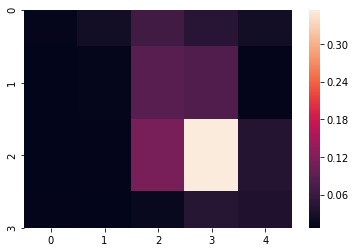

In [5]:
# test the thing
loc = Localise(colours, measurements, motions, sensor_right, p_move)
sns.heatmap(loc.p)

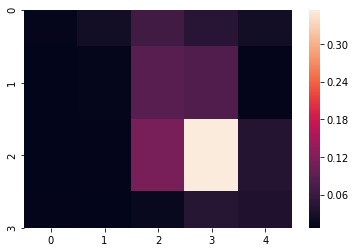

In [6]:
# test output should match the following
test_out = [
    [0.01105, 0.02464, 0.06799, 0.04472, 0.02465],
    [0.00715, 0.01017, 0.08696, 0.07988, 0.00935],
    [0.00739, 0.00894, 0.11272, 0.35350, 0.04065],
    [0.00910, 0.00715, 0.01434, 0.04313, 0.03642]
    ]

sns.heatmap(test_out)